# Caderno 4(b) - Calcula métricas considerando os resultados de pesquisa em um BM25 padrão. Indexa o enunciado 2 vezes (com peso 2)

In [1]:
# Se True, refaz a indexação. Se False, tenta recuperar o
# índice do arquivo indice_js_enunciado_e_excerto.pickle.
# É necessário que esse arquivo exista.
REINDEXAR_ENUNCIADO_EXCERTO = False

PASTA_DADOS = './dados/'
PASTA_RESULTADO_CADERNO = f'{PASTA_DADOS}outputs/4_metricas_bm25_padrao/'
NOME_ARQUIVO_INDICE_ENUNCIADO_E_EXCERTO = f'{PASTA_RESULTADO_CADERNO}indice_js_enunciado_2x_e_excerto.pickle'

## 1. Carrega base de dados

Carrega a lista de documentos para indexar, as queries para testar e o qrels.

In [2]:
import pandas as pd

# A pasta dos JURIS aqui não é a pasta original, e sim o resultado do caderno 1 (os documentos já estão filtrados)
PASTA_JURIS_TCU = f'{PASTA_DADOS}outputs/1_tratamento_juris_tcu/'

# Carrega os arquivos 
def carrega_juris_tcu():
    doc1 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_1.csv', sep='|')
    doc2 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_2.csv', sep='|')
    doc3 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_3.csv', sep='|')
    doc4 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_4.csv', sep='|')
    doc = pd.concat([doc1, doc2, doc3, doc4], ignore_index=True)
    query = pd.read_csv(f'{PASTA_JURIS_TCU}query_tratado.csv', sep='|')
    qrel = pd.read_csv(f'{PASTA_JURIS_TCU}qrel_tratado.csv', sep='|')

    return doc, query, qrel

docs, queries, qrels = carrega_juris_tcu()

## 2. Instancia um BM25 e indexa os campos ENUNCIADO e EXCERTO

In [3]:
from bm25 import IndiceInvertido, BM25, tokenizador_pt_remove_html

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [4]:
import os

# Vamos criar um índice invertido e indexar apenas o enunciado e excerto.
iidx = IndiceInvertido(tokenizador_pt_remove_html)

if REINDEXAR_ENUNCIADO_EXCERTO or not os.path.exists(NOME_ARQUIVO_INDICE_ENUNCIADO_E_EXCERTO):
    # Se for indexar a primeira vez:
    # Demora cerca de 35 minutos para indexar
    iidx.adiciona_dataframe(docs, lambda row: (row['KEY'], row['ENUNCIADO'] + ' ' + row['ENUNCIADO'] + ' ' + row['EXCERTO']))
    iidx.to_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_E_EXCERTO)
else:
    # Se quiser recuperar de um arquivo:
    iidx.from_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_E_EXCERTO)

In [5]:
print(iidx.get_tamanho_medio_docs())

505.72907447803055


In [6]:
# Agora instancia um BM25
buscador = BM25(iidx, k1=0.82, b=0.68, bias_idf=1)

## 3. Faz as pesquisas e salva os resultados

In [7]:
col_resultado_query_key=[]
col_resultado_doc_key=[]
col_resultado_rank=[]

for i, row in queries.iterrows():
    query_key = row.KEY
    query_text = row.TEXT
    resultados = buscador.pesquisar(query_text)

    primeiros_50_docs = [tupla_key_score[0] for tupla_key_score in resultados[:50]]
    queries_keys = [query_key] * len(primeiros_50_docs)
    ranking = list(range(1, len(primeiros_50_docs)+1))

    col_resultado_query_key.extend(queries_keys)
    col_resultado_doc_key.extend(primeiros_50_docs)
    col_resultado_rank.extend(ranking)

df_resultados = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key,
    "DOC_KEY": col_resultado_doc_key,
    "RANK": col_resultado_rank,
})

In [8]:
from metricas import metricas

df_metricas = metricas(df_resultados, qrels, aproximacao_trec_eval=True)

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.00,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.284000,0.28,0.225000,0.130400,0.114198,0.230358,0.372232,0.534729,0.534000,0.558103,0.564088,0.565267,0.302650,0.312387,0.382374,0.460818
std,14.57738,0.274315,0.20,0.132961,0.056603,0.105793,0.170199,0.234298,0.261099,0.442024,0.414613,0.406842,0.405214,0.281288,0.240120,0.242772,0.231602
min,1.00000,0.000000,0.00,0.000000,0.020000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.035966
25%,13.25000,0.000000,0.10,0.112500,0.080000,0.000000,0.076923,0.175000,0.307692,0.000000,0.148810,0.148810,0.148810,0.000000,0.078285,0.176116,0.270816
50%,25.50000,0.200000,0.30,0.225000,0.140000,0.083333,0.215385,0.374126,0.538462,0.500000,0.500000,0.500000,0.500000,0.283872,0.278261,0.355793,0.465473
75%,37.75000,0.400000,0.40,0.300000,0.180000,0.181818,0.379371,0.490385,0.755495,1.000000,1.000000,1.000000,1.000000,0.481513,0.501938,0.575460,0.660156
max,50.00000,1.000000,0.70,0.500000,0.220000,0.384615,0.571429,0.818182,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.842749,0.841333,0.841333


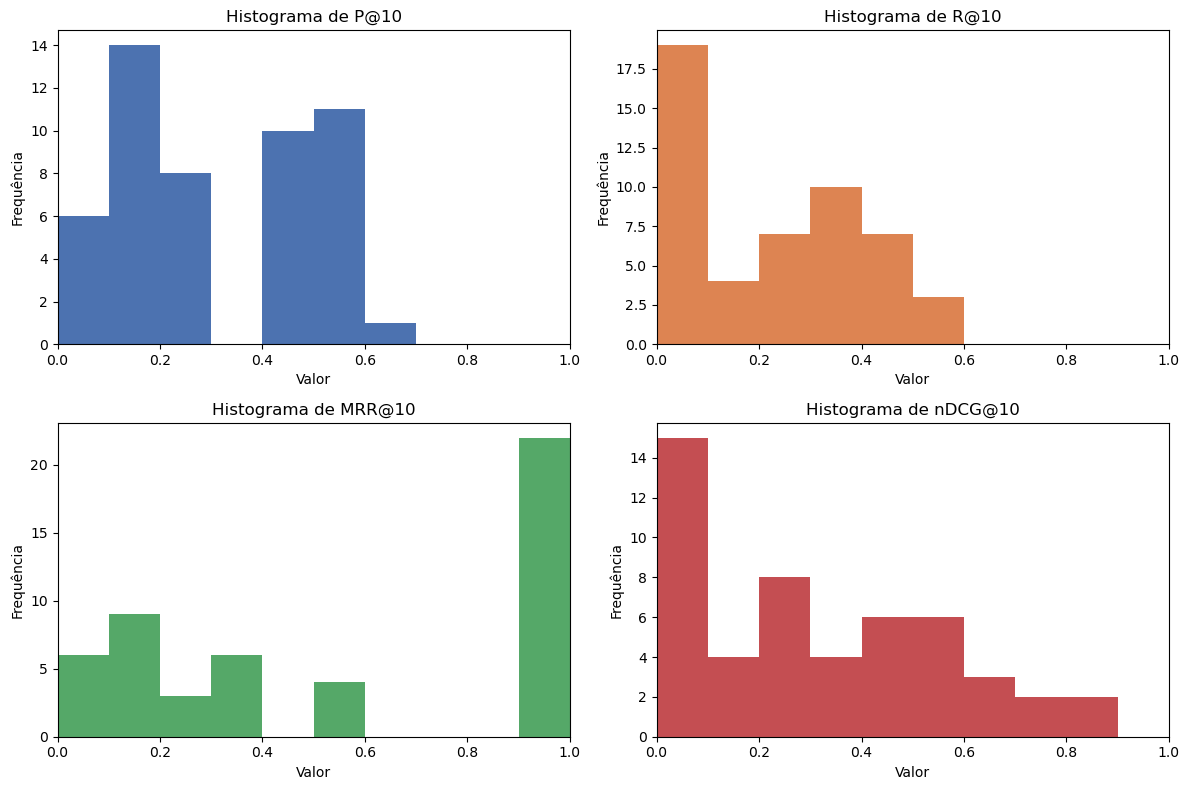

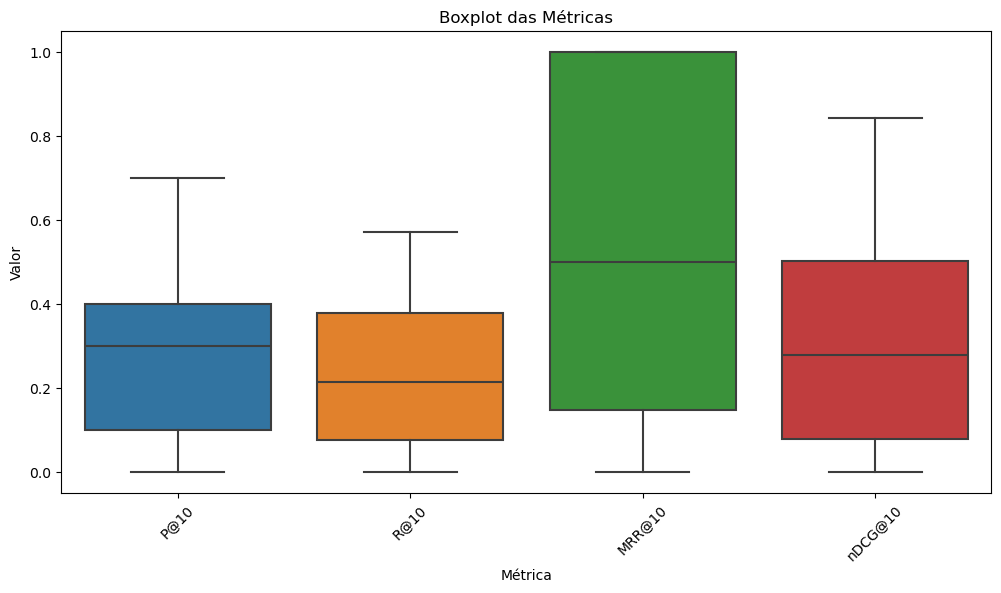

In [9]:
from metricas import histograma_metricas, boxplot_metricas

# Resultados para o primeiro grupo de queries:
display(df_metricas[0:50].describe())
histograma_metricas(df_metricas[0:50])
boxplot_metricas(df_metricas[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.552000,0.414000,0.269000,0.14280,0.232262,0.347402,0.450423,0.595131,0.940000,0.948889,0.948889,0.948889,0.643972,0.566798,0.593491,0.658529
std,14.57738,0.278656,0.205049,0.128528,0.04832,0.124070,0.185033,0.231870,0.219071,0.239898,0.204460,0.204460,0.204460,0.236177,0.184153,0.194715,0.174049
min,51.00000,0.000000,0.100000,0.050000,0.02000,0.000000,0.071429,0.076923,0.083333,0.000000,0.111111,0.111111,0.111111,0.000000,0.051685,0.149341,0.150664
25%,63.25000,0.400000,0.225000,0.150000,0.10500,0.153846,0.230769,0.275974,0.428571,1.000000,1.000000,1.000000,1.000000,0.497288,0.454167,0.455412,0.553728
50%,75.50000,0.600000,0.400000,0.250000,0.16000,0.230769,0.333333,0.408333,0.615385,1.000000,1.000000,1.000000,1.000000,0.669617,0.590890,0.616861,0.668575
75%,87.75000,0.800000,0.600000,0.387500,0.18000,0.333333,0.459790,0.611538,0.750000,1.000000,1.000000,1.000000,1.000000,0.798033,0.695491,0.703296,0.771643
max,100.00000,1.000000,0.800000,0.500000,0.20000,0.500000,0.800000,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.863743,0.935646,0.957398


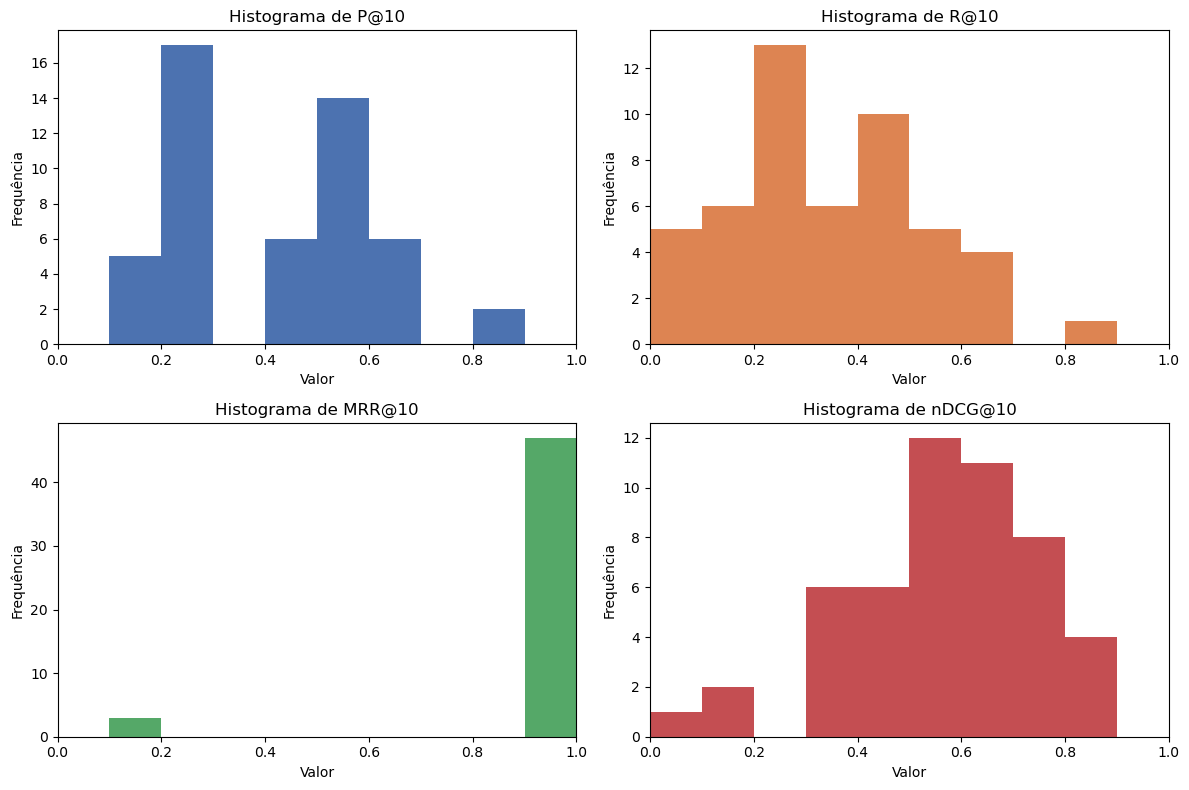

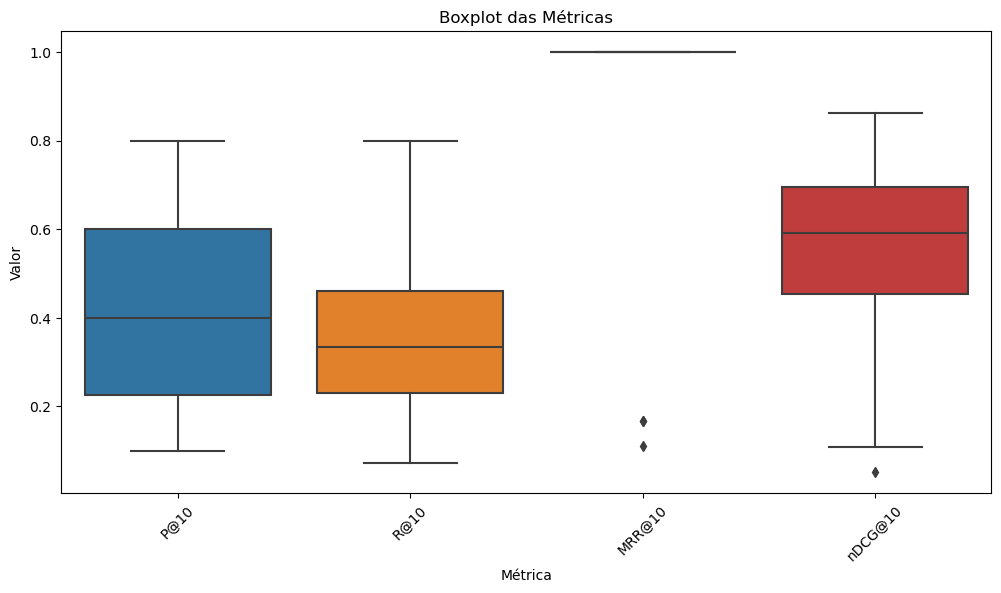

In [10]:
# Resultados para o primeiro grupo de queries:
display(df_metricas[50:100].describe())
histograma_metricas(df_metricas[50:100])
boxplot_metricas(df_metricas[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.544000,0.39600,0.269000,0.139600,0.244305,0.351814,0.474964,0.614040,0.945000,0.947222,0.947222,0.947222,0.634517,0.551954,0.601993,0.658090
std,14.57738,0.255678,0.20199,0.125718,0.051188,0.121804,0.178341,0.220196,0.223271,0.197497,0.186993,0.186993,0.186993,0.214074,0.184597,0.185414,0.168065
min,101.00000,0.000000,0.10000,0.050000,0.020000,0.000000,0.066667,0.066667,0.100000,0.000000,0.111111,0.111111,0.111111,0.000000,0.070969,0.231365,0.276223
25%,113.25000,0.400000,0.22500,0.200000,0.100000,0.166667,0.230769,0.340909,0.456294,1.000000,1.000000,1.000000,1.000000,0.507790,0.452679,0.457162,0.526745
50%,125.50000,0.600000,0.40000,0.250000,0.140000,0.250000,0.333333,0.500000,0.625874,1.000000,1.000000,1.000000,1.000000,0.657824,0.561523,0.635123,0.697877
75%,137.75000,0.800000,0.50000,0.350000,0.180000,0.333333,0.459790,0.611538,0.750000,1.000000,1.000000,1.000000,1.000000,0.784621,0.693797,0.768178,0.790006
max,150.00000,1.000000,0.90000,0.500000,0.220000,0.500000,0.818182,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.877208,0.942944,0.942944


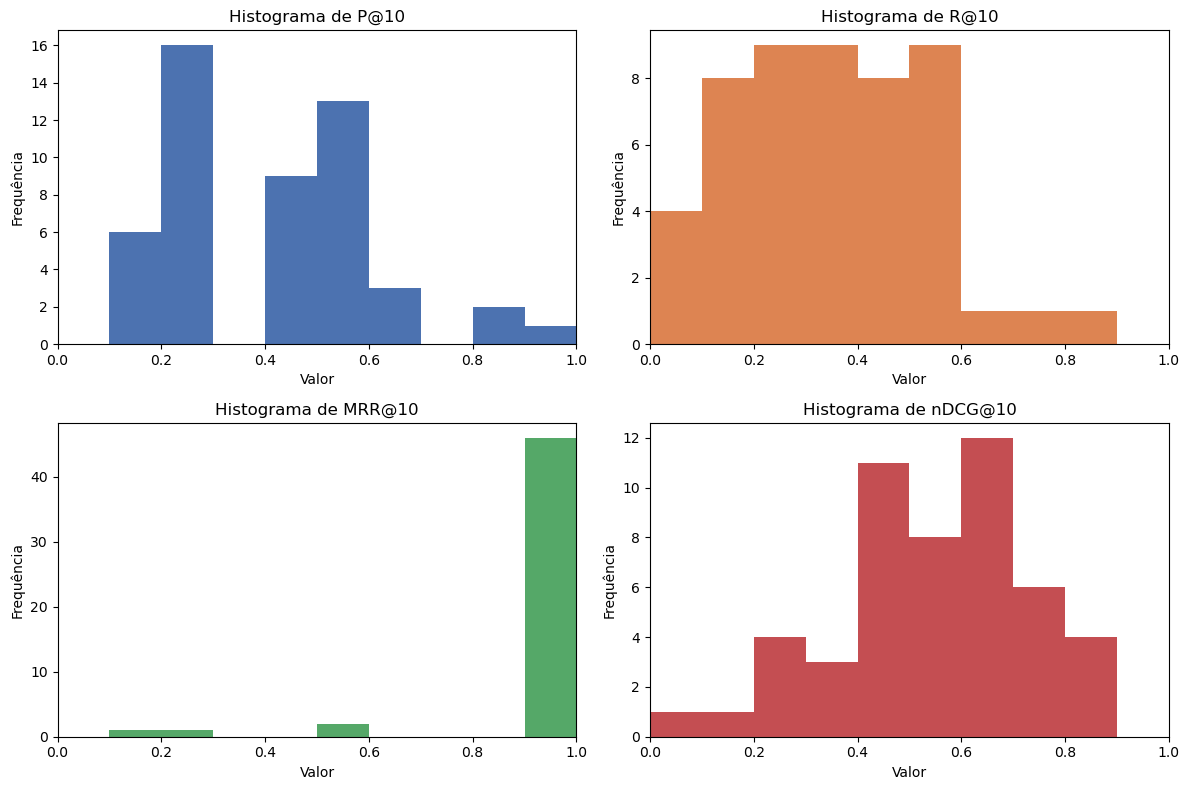

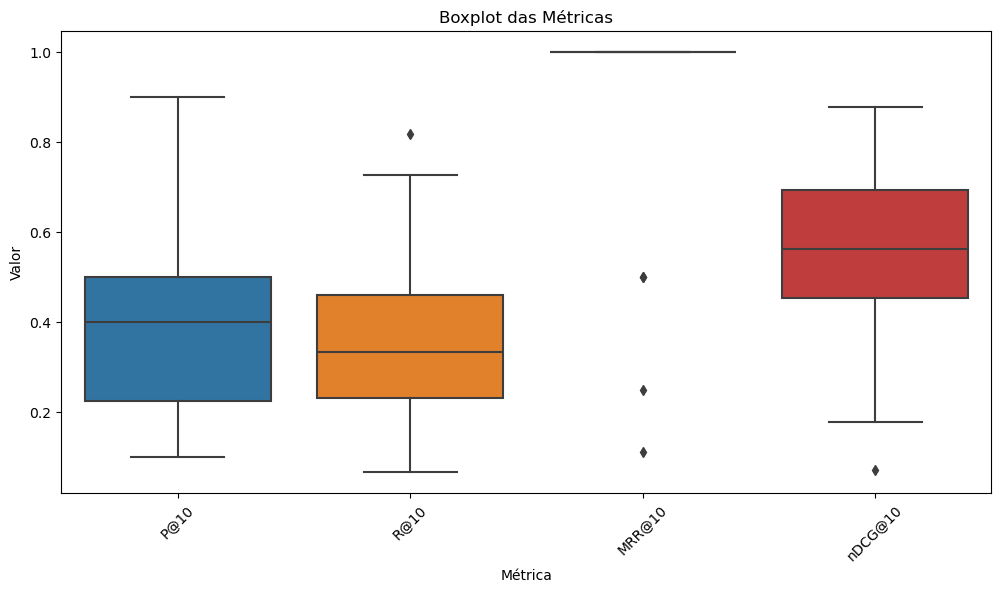

In [11]:
# Resultados para o primeiro grupo de queries:
display(df_metricas[100:150].describe())
histograma_metricas(df_metricas[100:150])
boxplot_metricas(df_metricas[100:150])